In [1]:

import jax
jax.config.update('jax_enable_x64',True)
import jax.random as random
from jax import jit

import pickle

In [2]:


import numpyro
from NSF import NeuralSpline1D
from flow import Normal,Flow,transform,Serial
from SkewNormalPlus import SkewNormalPlus as snp

/home/bmb41/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from jax import random
import jax_cosmo as jc
from jax_cosmo import Cosmology, background
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax.scipy.stats import norm

In [4]:

@jit
def make_training_set(key,z_s,M0=-19.5,sigma_int=0.1,h=0.7324,Om0=0.28,w=-1,mu_cut=21,sigma_cut=0.01):




    cosmo_jax = Cosmology(Omega_c=Om0, h=h, w0=w, Omega_b=0, n_s= 0.96, sigma8=200000, Omega_k=0, wa=0)

    n_sne=len(z_s)

    d_s=background.transverse_comoving_distance(cosmo_jax, 1/(1+z_s))

    mu_s=5*np.log10((1+z_s)/h*d_s*1e6/10)

    m0_s=M0+mu_s

    m_s=random.normal(key, (len(m0_s),))*sigma_int+m0_s

    key, _ = random.split(key)

    p_s=norm.cdf(-m_s, loc=-mu_cut, scale=sigma_cut)

    sel_s=random.bernoulli(key, p=p_s)

    return m0_s,m_s,sel_s


@jit
def minmax_fit_and_scale(X):
  max= np.max(X,axis=0)
  min = np.min(X,axis=0)
  X_std = (X - min) / (max-min)
  return X_std,min,max

@jit
def minmax_scale(X,min,max):
  return (X - min) / (max - min)

@jit
def minmax_unscale(X,min,max):
  return X * (max - min) + min




In [5]:
from jax.example_libraries import stax, optimizers

from jax.example_libraries.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, Softmax, Exp,Sigmoid,Softplus,LeakyRelu)

def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Relu, stax.Dense(1024),  Relu, stax.Dense(1024),Relu,stax.Dense(hidden_dim), Relu, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))

    return params,apply_fun
'''
def network(rng,conditional_dim,out_dim, hidden_dim):
    init_fun,apply_fun=stax.serial(stax.Dense(hidden_dim), Tanh, stax.Dense(1024),Tanh,stax.Dense(hidden_dim), Tanh, stax.Dense(out_dim),)
    _, params = init_fun(rng, (conditional_dim,))
    return params,apply_fun
'''
rng, flow_rng = random.split(random.PRNGKey(0))

init_fun = Flow(Serial(*(NeuralSpline1D(network,hidden_dim=256,K=40,B=5),)*5),prior=Normal())

params, log_pdf, sample = init_fun(flow_rng,2 )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-3)
opt_state = opt_init(params)

In [7]:
def loss_fn(params, inputs):
    return -log_pdf(params, inputs).mean()

@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)

    loss,gradients = value_and_grad(loss_fn)(params,inputs)
    return loss, opt_update(i, gradients, opt_state)



epoch:  0  loss:  1.8552443667597964


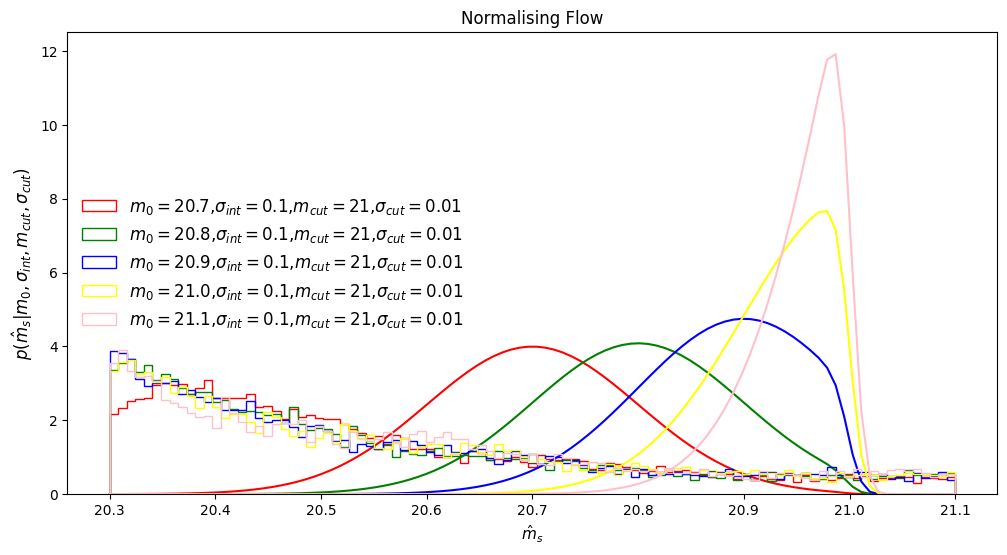

epoch:  1  loss:  1.9682052345915646
epoch:  2  loss:  4.449468451713485
epoch:  3  loss:  1.77480116240174
epoch:  4  loss:  1.1409335191254335
epoch:  5  loss:  2.2011108315905883
epoch:  6  loss:  1.0242923668621293
epoch:  7  loss:  0.9531226474069512
epoch:  8  loss:  0.8906655802164695
epoch:  9  loss:  0.5627355308858587
epoch:  10  loss:  0.23494443327843123
epoch:  11  loss:  1.4312524822636856
epoch:  12  loss:  1.0961240856164733
epoch:  13  loss:  0.10979679198903818
epoch:  14  loss:  0.5241319033052783
epoch:  15  loss:  0.3691657013099365
epoch:  16  loss:  0.417667718396779
epoch:  17  loss:  0.21362704601628513
epoch:  18  loss:  0.21790705711676953
epoch:  19  loss:  -0.14969902867780702
epoch:  20  loss:  0.5296504998428564
epoch:  21  loss:  0.3680701733360708
epoch:  22  loss:  0.056349462089906044
epoch:  23  loss:  0.27883544462082027
epoch:  24  loss:  0.01698538428692281
epoch:  25  loss:  0.018794038192894526
epoch:  26  loss:  -0.10190410972979946
epoch:  27 

epoch:  209  loss:  -0.7226344875292278
epoch:  210  loss:  -0.5235079248794138
epoch:  211  loss:  -0.8842910780925898
epoch:  212  loss:  -1.1525406018007356
epoch:  213  loss:  -0.914931560957117
epoch:  214  loss:  -1.4115699426412602
epoch:  215  loss:  -0.6811655157753946
epoch:  216  loss:  -0.914361820700981
epoch:  217  loss:  -0.8977269323784232
epoch:  218  loss:  -0.8381099916604837
epoch:  219  loss:  -1.2513914382215687
epoch:  220  loss:  -0.4972527414582776
epoch:  221  loss:  -1.4823522167244494
epoch:  222  loss:  -1.5079016059220756
epoch:  223  loss:  -1.2922657961114605
epoch:  224  loss:  -1.1434084650096807
epoch:  225  loss:  -0.7343859853552676
epoch:  226  loss:  -0.7718183497195802
epoch:  227  loss:  -0.7240265489374756
epoch:  228  loss:  -1.0084293590483704
epoch:  229  loss:  -0.7207887803537181
epoch:  230  loss:  -0.9930982528346037
epoch:  231  loss:  -1.2854683160749965
epoch:  232  loss:  -1.0605324999322063
epoch:  233  loss:  -0.7634503245130478
ep

epoch:  414  loss:  -1.3038408721707417
epoch:  415  loss:  -0.9588712581934656
epoch:  416  loss:  -1.3209621517342431
epoch:  417  loss:  -0.9856141700686383
epoch:  418  loss:  -0.5892919965242172
epoch:  419  loss:  -0.39296126345347954
epoch:  420  loss:  -0.5057850963162954
epoch:  421  loss:  -0.592375379217981
epoch:  422  loss:  -0.678081516826914
epoch:  423  loss:  -1.2741962086926284
epoch:  424  loss:  -0.6866307508643164
epoch:  425  loss:  -1.3269269671944186
epoch:  426  loss:  -1.0615703114280723
epoch:  427  loss:  -1.3035180461766505
epoch:  428  loss:  -1.2266183223488274
epoch:  429  loss:  -1.1320293957666314
epoch:  430  loss:  -1.3816288542789585
epoch:  431  loss:  -0.8929357238576191
epoch:  432  loss:  -0.7844824355584813
epoch:  433  loss:  -0.7686240427290859
epoch:  434  loss:  -1.0948628939386482
epoch:  435  loss:  -0.9890135183339653
epoch:  436  loss:  -0.5861077375350469
epoch:  437  loss:  -0.9931979545454376
epoch:  438  loss:  -1.1575648178352005
e

epoch:  620  loss:  -0.8457880973215632
epoch:  621  loss:  -0.7798016074299468
epoch:  622  loss:  -0.8481967778649709
epoch:  623  loss:  -0.9133199982708737
epoch:  624  loss:  -0.9230766239076168
epoch:  625  loss:  -0.9999609181203083
epoch:  626  loss:  -0.6057786045581235
epoch:  627  loss:  -0.7174175584299358
epoch:  628  loss:  -1.2034245294507362
epoch:  629  loss:  -1.0893706816912267
epoch:  630  loss:  -1.2807261836284523
epoch:  631  loss:  -1.1449449549251454
epoch:  632  loss:  -1.140347681207615
epoch:  633  loss:  -1.19808718385514
epoch:  634  loss:  -0.8098835464498825
epoch:  635  loss:  -0.9507936479261994
epoch:  636  loss:  -0.6242518077599379
epoch:  637  loss:  -0.6242901881833293
epoch:  638  loss:  -1.08952827164237
epoch:  639  loss:  -1.1418936997396558
epoch:  640  loss:  -1.3387053458421183
epoch:  641  loss:  -0.7252925894166782
epoch:  642  loss:  -1.4626047761993697
epoch:  643  loss:  -1.0648023533887827
epoch:  644  loss:  -1.1317858204355504
epoch

epoch:  826  loss:  -0.5136990749942081
epoch:  827  loss:  -1.0998018829751486
epoch:  828  loss:  -1.1524674024212318
epoch:  829  loss:  -1.0225609286364448
epoch:  830  loss:  -1.5952129735933391
epoch:  831  loss:  -1.0861120577123535
epoch:  832  loss:  -0.9101342853498263
epoch:  833  loss:  -1.0595676661182838
epoch:  834  loss:  -1.1330641154244536
epoch:  835  loss:  -1.2908410675899797
epoch:  836  loss:  -0.6137619218312607
epoch:  837  loss:  -1.2507488110678837
epoch:  838  loss:  -1.1579072150292093
epoch:  839  loss:  -0.6886997868905669
epoch:  840  loss:  -1.6589558278557681
epoch:  841  loss:  -0.7856274752216277
epoch:  842  loss:  -0.7251783396773037
epoch:  843  loss:  -0.9857745532565794
epoch:  844  loss:  -1.072919026938401
epoch:  845  loss:  -1.0526337180711707
epoch:  846  loss:  -1.2707902756328955
epoch:  847  loss:  -1.2162732819897895
epoch:  848  loss:  -0.8173332769247893
epoch:  849  loss:  -0.9803468445775222
epoch:  850  loss:  -0.6732185250926402
e

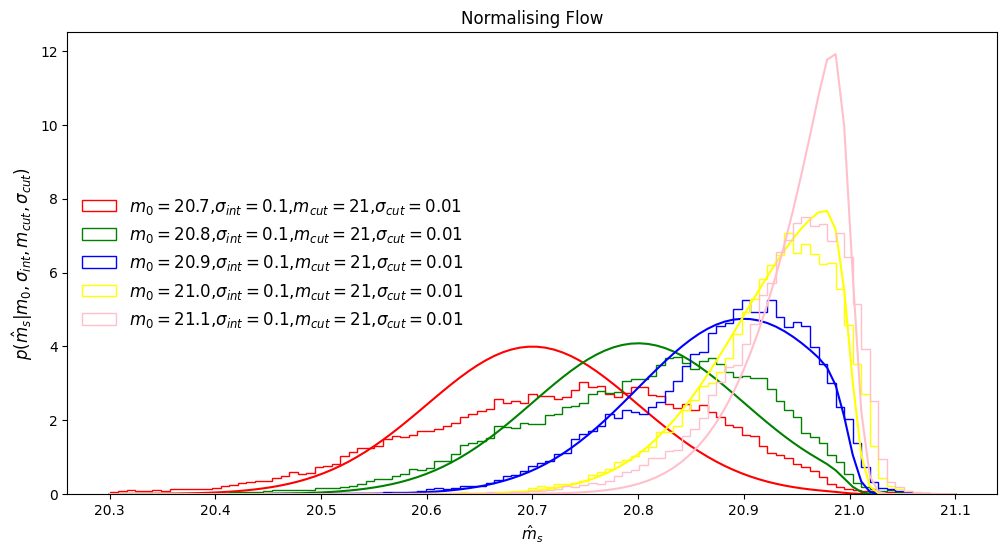

epoch:  1001  loss:  -0.6928703643798808
epoch:  1002  loss:  -1.308887954728773
epoch:  1003  loss:  -0.6454082221130572
epoch:  1004  loss:  -0.9346355797481751
epoch:  1005  loss:  -0.7706162213041619
epoch:  1006  loss:  -1.251316435410928
epoch:  1007  loss:  -0.8342171148675284
epoch:  1008  loss:  -0.9933269597021789
epoch:  1009  loss:  -1.2810256144079972
epoch:  1010  loss:  -1.5086977384359501
epoch:  1011  loss:  -1.2380073459204224
epoch:  1012  loss:  -0.6614379297413191
epoch:  1013  loss:  -1.15096389792253
epoch:  1014  loss:  -0.9230631006832092
epoch:  1015  loss:  -1.3736151449029932
epoch:  1016  loss:  -0.8606554926137037
epoch:  1017  loss:  -0.9765439950163377
epoch:  1018  loss:  -1.2431046718994534
epoch:  1019  loss:  -1.3652909956721715
epoch:  1020  loss:  -0.843106962867257
epoch:  1021  loss:  -1.0450363415758548
epoch:  1022  loss:  -0.873815244278773
epoch:  1023  loss:  -0.6310843687985558
epoch:  1024  loss:  -1.1467606939589514
epoch:  1025  loss:  -

epoch:  1202  loss:  -1.38878739088454
epoch:  1203  loss:  -1.0734524781803931
epoch:  1204  loss:  -1.1537764026494388
epoch:  1205  loss:  -1.1161024978516871
epoch:  1206  loss:  -1.6803384822478074
epoch:  1207  loss:  -1.1590672927079215
epoch:  1208  loss:  -1.3526651468908804
epoch:  1209  loss:  -0.7015395990023247
epoch:  1210  loss:  -0.7436109039532918
epoch:  1211  loss:  -1.2940647639136136
epoch:  1212  loss:  -0.7339420875941084
epoch:  1213  loss:  0.008626571187245179
epoch:  1214  loss:  -0.2919257151440198
epoch:  1215  loss:  -0.4828487946693449
epoch:  1216  loss:  -0.6589168107196429
epoch:  1217  loss:  -0.5069598966070992
epoch:  1218  loss:  -0.47247001786569187
epoch:  1219  loss:  -0.8039782006844166
epoch:  1220  loss:  -0.3680990026474476
epoch:  1221  loss:  -0.5067282872248201
epoch:  1222  loss:  -0.5681543203656149
epoch:  1223  loss:  -0.8043733365684258
epoch:  1224  loss:  -1.0093441122470648
epoch:  1225  loss:  -0.4301405548418052
epoch:  1226  lo

epoch:  1403  loss:  -1.0689895509537244
epoch:  1404  loss:  -0.8393027773946912
epoch:  1405  loss:  -1.2088560868680842
epoch:  1406  loss:  -0.8036581226613374
epoch:  1407  loss:  -1.212443782591004
epoch:  1408  loss:  -1.0046934798812424
epoch:  1409  loss:  -1.1356881918350241
epoch:  1410  loss:  -1.596992286580981
epoch:  1411  loss:  -0.6328387019449531
epoch:  1412  loss:  -1.5645979564040267
epoch:  1413  loss:  -1.1970344333296183
epoch:  1414  loss:  -0.961290250125388
epoch:  1415  loss:  -1.2143461040465635
epoch:  1416  loss:  -1.3528527884298214
epoch:  1417  loss:  -1.07953497051438
epoch:  1418  loss:  -1.6990915353505471
epoch:  1419  loss:  -0.6829500963738917
epoch:  1420  loss:  -0.9828602909384254
epoch:  1421  loss:  -0.9972666917512549
epoch:  1422  loss:  -1.2106914231441523
epoch:  1423  loss:  -0.949096925924241
epoch:  1424  loss:  -0.7169791313511943
epoch:  1425  loss:  -0.47599943738264633
epoch:  1426  loss:  -0.8186921371805379
epoch:  1427  loss:  

epoch:  1604  loss:  -1.1527435438789886
epoch:  1605  loss:  -1.357140757723016
epoch:  1606  loss:  -0.7928513485062509
epoch:  1607  loss:  -1.2776615986209396
epoch:  1608  loss:  -0.9386224192730674
epoch:  1609  loss:  -0.7623630964761747
epoch:  1610  loss:  -0.915204483818183
epoch:  1611  loss:  -1.196976380818022
epoch:  1612  loss:  -1.157274151040274
epoch:  1613  loss:  -1.2693023898104465
epoch:  1614  loss:  -0.8079071128158902
epoch:  1615  loss:  -0.7867464874166896
epoch:  1616  loss:  -0.6939493588724441
epoch:  1617  loss:  -1.0542185248073905
epoch:  1618  loss:  -1.4820443636620224
epoch:  1619  loss:  -1.5542127748876169
epoch:  1620  loss:  -0.7375291876244937
epoch:  1621  loss:  -0.9151419971479766
epoch:  1622  loss:  -1.142374649597782
epoch:  1623  loss:  -0.9378665350271959
epoch:  1624  loss:  -0.6704930654331256
epoch:  1625  loss:  -0.8559223446675258
epoch:  1626  loss:  -0.7878228166094617
epoch:  1627  loss:  -0.8847240384472211
epoch:  1628  loss:  

epoch:  1805  loss:  -0.9900341117069995
epoch:  1806  loss:  -0.885700543185028
epoch:  1807  loss:  -0.849236339028258
epoch:  1808  loss:  -0.3956910539656573
epoch:  1809  loss:  -1.549495280309244
epoch:  1810  loss:  -1.8587118285350026
epoch:  1811  loss:  -1.1482346132547874
epoch:  1812  loss:  -0.8694261509931258
epoch:  1813  loss:  -1.6591159444438186
epoch:  1814  loss:  -1.2227823136543907
epoch:  1815  loss:  -0.8573835485089221
epoch:  1816  loss:  -0.897725545427768
epoch:  1817  loss:  -0.6479184564821935
epoch:  1818  loss:  -0.989769761851396
epoch:  1819  loss:  -1.2024435821915795
epoch:  1820  loss:  -0.8504865384283551
epoch:  1821  loss:  -1.5274915834187532
epoch:  1822  loss:  -1.1074350800576016
epoch:  1823  loss:  -0.7003329706601907
epoch:  1824  loss:  -0.5131865285136981
epoch:  1825  loss:  -1.1050317039434667
epoch:  1826  loss:  -1.2358680231486017
epoch:  1827  loss:  -1.1909333763520085
epoch:  1828  loss:  -1.0031263403044923
epoch:  1829  loss:  

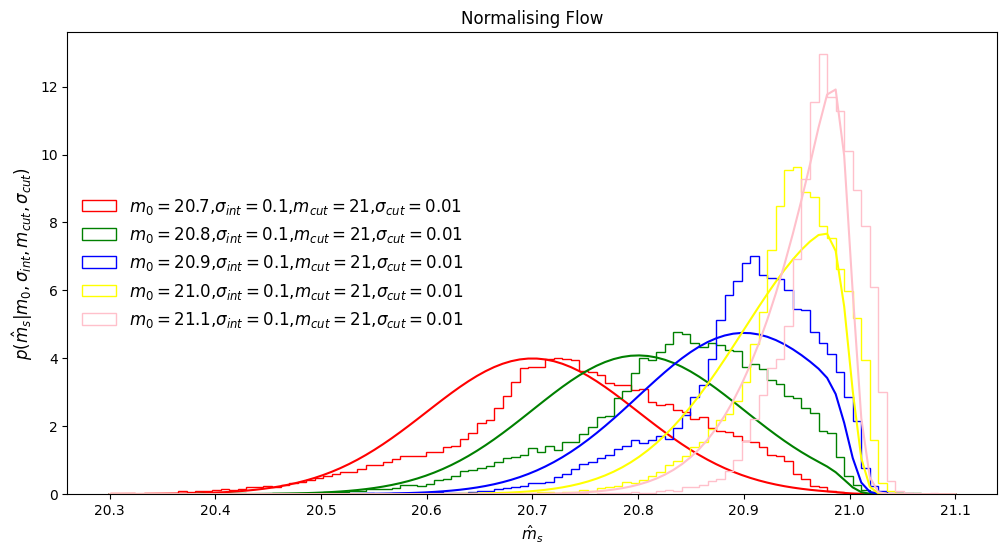

epoch:  2001  loss:  -0.6896148617195053
epoch:  2002  loss:  -1.2584609460043257
epoch:  2003  loss:  -0.5279282679168764
epoch:  2004  loss:  -0.9781265014790624
epoch:  2005  loss:  -0.5244047911168627
epoch:  2006  loss:  -1.1755634176425083
epoch:  2007  loss:  -1.1522758839738076
epoch:  2008  loss:  -0.8512806339050911
epoch:  2009  loss:  -0.8514407564889518
epoch:  2010  loss:  -0.5933033529283086
epoch:  2011  loss:  -0.894376443555652
epoch:  2012  loss:  -1.6779077094302592
epoch:  2013  loss:  -0.7259697450314975
epoch:  2014  loss:  -0.7508566811340024
epoch:  2015  loss:  -1.3211711680830123
epoch:  2016  loss:  -1.2764275273135879
epoch:  2017  loss:  -1.3032392071746077
epoch:  2018  loss:  -0.7709232589182037
epoch:  2019  loss:  -1.1112854219232646
epoch:  2020  loss:  -0.8041190805469246
epoch:  2021  loss:  -1.668570186965486
epoch:  2022  loss:  -0.9563931049748444
epoch:  2023  loss:  -1.2369907824368676
epoch:  2024  loss:  -1.3550496970449049
epoch:  2025  loss

epoch:  2202  loss:  -1.3851468322239484
epoch:  2203  loss:  -1.2347513834100092
epoch:  2204  loss:  -0.8607951420915838
epoch:  2205  loss:  -0.9837507609713384
epoch:  2206  loss:  -1.1811910908800924
epoch:  2207  loss:  -0.8987017161486222
epoch:  2208  loss:  -1.5307250270381645
epoch:  2209  loss:  -1.1088132586646922
epoch:  2210  loss:  -1.1759673285201062
epoch:  2211  loss:  -1.4623296962553696
epoch:  2212  loss:  -0.6160631317312204
epoch:  2213  loss:  -0.9990791742599908
epoch:  2214  loss:  -1.3475457764187386
epoch:  2215  loss:  -0.8817740235034773
epoch:  2216  loss:  -1.6865372511339904
epoch:  2217  loss:  -1.3614029686374278
epoch:  2218  loss:  -1.0701368575244345
epoch:  2219  loss:  -0.9170337119143576
epoch:  2220  loss:  -1.1886629346944864
epoch:  2221  loss:  -0.655843145048264
epoch:  2222  loss:  -1.5589662044586639
epoch:  2223  loss:  -1.3673251537620792
epoch:  2224  loss:  -1.7511302917349372
epoch:  2225  loss:  -1.1778997568433514
epoch:  2226  los

epoch:  2403  loss:  -0.9857842704325461
epoch:  2404  loss:  -0.6044046089308351
epoch:  2405  loss:  -1.4889025804543252
epoch:  2406  loss:  -1.178709834634742
epoch:  2407  loss:  -0.898413795277047
epoch:  2408  loss:  -0.9412189844969535
epoch:  2409  loss:  -0.6102443053188167
epoch:  2410  loss:  -0.7719220494478344
epoch:  2411  loss:  -1.1128523313425722
epoch:  2412  loss:  -1.4198208281140252
epoch:  2413  loss:  -1.0961989922384847
epoch:  2414  loss:  -0.8798309710160512
epoch:  2415  loss:  -1.0282899674135062
epoch:  2416  loss:  -1.0392327756469786
epoch:  2417  loss:  -1.2905222031997838
epoch:  2418  loss:  -1.076489686484023
epoch:  2419  loss:  -0.9475181730093932
epoch:  2420  loss:  -1.2623643498209072
epoch:  2421  loss:  -1.1080105874026145
epoch:  2422  loss:  -1.2053995517245621
epoch:  2423  loss:  -1.4428731357928128
epoch:  2424  loss:  -0.7472104707519769
epoch:  2425  loss:  -1.1010133390232473
epoch:  2426  loss:  -0.96787323849909
epoch:  2427  loss:  

epoch:  2604  loss:  -1.3502500377903575
epoch:  2605  loss:  -1.040937934277167
epoch:  2606  loss:  -1.1536528745039851
epoch:  2607  loss:  -0.7754461673186628
epoch:  2608  loss:  -1.2047915771556805
epoch:  2609  loss:  -0.8952605362809527
epoch:  2610  loss:  -0.6734263248549973
epoch:  2611  loss:  -0.8693316258815452
epoch:  2612  loss:  -0.968922241027942
epoch:  2613  loss:  -0.8886925711929903
epoch:  2614  loss:  -1.3374396530050763
epoch:  2615  loss:  -0.9856433980839665
epoch:  2616  loss:  -0.9834360852103035
epoch:  2617  loss:  -1.0568736829132621
epoch:  2618  loss:  -1.376945330983894
epoch:  2619  loss:  -0.538968863614512
epoch:  2620  loss:  -1.1902446064967047
epoch:  2621  loss:  -1.447305697506864
epoch:  2622  loss:  -1.3836163302508362
epoch:  2623  loss:  -1.617306363269284
epoch:  2624  loss:  -1.3738489264813565
epoch:  2625  loss:  -1.316844938741322
epoch:  2626  loss:  -1.5348048094090339
epoch:  2627  loss:  -1.44727204706669
epoch:  2628  loss:  -0.9

epoch:  2805  loss:  -1.1481187300531523
epoch:  2806  loss:  -0.9562591442320822
epoch:  2807  loss:  -1.4067180496414542
epoch:  2808  loss:  -1.2890569828100562
epoch:  2809  loss:  -1.4476132899608454
epoch:  2810  loss:  -1.6224735195698359
epoch:  2811  loss:  -1.518115631354156
epoch:  2812  loss:  -0.8752280013354466
epoch:  2813  loss:  -1.1780163226439013
epoch:  2814  loss:  -0.9760908135258372
epoch:  2815  loss:  -1.2721537138603551
epoch:  2816  loss:  -1.057759124778868
epoch:  2817  loss:  -1.1319297495874936
epoch:  2818  loss:  -0.8140063309016428
epoch:  2819  loss:  -2.48520565481022
epoch:  2820  loss:  -1.1155296209878156
epoch:  2821  loss:  -1.9146485485341633
epoch:  2822  loss:  -0.37355271799140166
epoch:  2823  loss:  -0.3609182362510684
epoch:  2824  loss:  -0.3478103676695996
epoch:  2825  loss:  -0.3691183079499043
epoch:  2826  loss:  -0.9315029442559224
epoch:  2827  loss:  -0.26192466517042357
epoch:  2828  loss:  -0.7874868705729321
epoch:  2829  loss

In [ ]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr
itercount = itertools.count()
sample_batch=1000
batch_size=1000
import logging
itercount = itertools.count()
from IPython.display import clear_output

from matplotlib import pyplot as plt

batch_size=500



for epoch in range(10000):
    
    
  X = np.empty((0,3))
 
  for s_epoch in range(5):
    
      permute_rng, rng = random.split(rng)
      sigma_int =   np.absolute(random.normal(rng,(1,)))*0.2  
      #sigma_int =   random.uniform(rng,(1,))*0.5

  
      sigma_cut=0.01
      mu_cut= 21

      permute_rng, rng = random.split(rng)


      mu=random.uniform(rng,(10,))*(21+2*sigma_int[0]-20.5) + 20.5


      s = snp(m_int=mu,sigma_int=sigma_int,m_cut=mu_cut,sigma_cut=sigma_cut)

      permute_rng, rng = random.split(rng)
      

      samps=s.sample(rng,(20,10))
        
      permute_rng, rng = random.split(rng)



      theta = np.column_stack((np.repeat(mu,20).T.reshape(200,1),np.repeat(sigma_int,200).reshape(200,1)))
    

        
      X_ = np.column_stack((samps.T.reshape(200,1),theta))
    
      X = np.append(X,X_,axis=0)


  if epoch == 0:
      X,min,max=minmax_fit_and_scale(X)

    
  else:
      X  = minmax_scale(X,min,max)



  loss,opt_state = step(next(itercount), opt_state, X)
  params = get_params(opt_state)

  print('epoch: ',epoch,' loss: ', loss)

  
  if epoch % 1000 == 0:
    
    c=['red','green','blue','yellow','pink']
    mm = np.array([20.7,20.8,20.9,21,21.1])
    bins=np.linspace(20.3,21.1,100)
    no_samps = 50000


    plt.figure(figsize=(12,6))

    for i,m in enumerate(mm):
    


            samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.1]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            samp = minmax_unscale(samp[:,0],min[0],max[0])

            plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=0.1$,$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
            s=snp(np.array([m]),np.array([0.1]),21,0.01)
            plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])


            

    plt.legend(loc='center left',frameon=False,fontsize=12)
    plt.xlabel('$\hat{m}_s$',fontsize=11)
    plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
    plt.title('Normalising Flow',fontsize=12)

    trained_params = optimizers.unpack_optimizer_state(opt_state)
    pickle.dump(trained_params, open('flow2d_opt.pkl', "wb"))


    plt.show()

trained_params = optimizers.unpack_optimizer_state(opt_state)
pickle.dump(trained_params, open('flow2d_opt.pkl', "wb"))


In [ ]:
from matplotlib import pyplot as plt
c=['red','green','blue','yellow','pink']
mm = np.array([20.7,20.8,20.9,21,21.1])
bins=np.linspace(20.3,21.1,100)
no_samps = 100000


plt.figure(figsize=(12,6))



for i,m in enumerate(mm):
    

    samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.1]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            
    samp = minmax_unscale(samp[:,0],min[0],max[0])


    plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str('0.1')+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
    s=snp(np.array([m]),np.array([0.1]),21,0.01)
    plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
    print(np.min(samp),np.max(samp))

    #plt.hist(s.sample(rng,(1000,1)).reshape(1000,),density=True,histtype='step')
    

plt.legend(loc='upper right',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Normalising Flow',fontsize=12)
plt.xlim(21.1,20.3)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
c=['red','green','blue','yellow','pink']
mm = np.array([20.7,20.8,20.9,21,21.1])
bins=np.linspace(20.3,21.1,100)
no_samps = 100000


plt.figure(figsize=(12,6))



for i,m in enumerate(mm):
    

    samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.2]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            
    samp = minmax_unscale(samp[:,0],min[0],max[0])


    plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str('0.2')+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
    s=snp(np.array([m]),np.array([0.2]),21,0.01)
    plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
    print(np.min(samp),np.max(samp))

    #plt.hist(s.sample(rng,(1000,1)).reshape(1000,),density=True,histtype='step')
    

plt.legend(loc='upper right',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Normalising Flow',fontsize=12)
plt.xlim(21.1,20.3)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
c=['red','green','blue','yellow','pink']
mm = np.array([20.7,20.8,20.9,21,21.1])
bins=np.linspace(20.3,21.1,100)
no_samps = 100000


plt.figure(figsize=(12,6))



for i,m in enumerate(mm):
    

    samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.05]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            
    samp = minmax_unscale(samp[:,0],min[0],max[0])


    plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str('0.05')+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
    s=snp(np.array([m]),np.array([0.05]),21,0.01)
    plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
    print(np.min(samp),np.max(samp))

    #plt.hist(s.sample(rng,(1000,1)).reshape(1000,),density=True,histtype='step')
    

plt.legend(loc='upper right',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Normalising Flow',fontsize=12)
plt.xlim(21.1,20.3)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
c=['red','green','blue','yellow','pink']
mm = np.array([20.7,20.8,20.9,21,21.1])
bins=np.linspace(20.3,21.1,100)
no_samps = 100000


plt.figure(figsize=(12,6))



for i,m in enumerate(mm):
    

    samp=sample(rng, params,minmax_scale(np.column_stack((np.repeat(np.array([m]),no_samps).reshape(no_samps,1),np.array([0.01]*no_samps).reshape(no_samps,1))),min[1:],max[1:]),no_samps)
            
    samp = minmax_unscale(samp[:,0],min[0],max[0])


    plt.hist(samp,density=True,bins=bins,color=c[i],histtype='step',label='$m_0=$'+str(m)+',$\sigma_{int}=$'+str('0.01')+',$m_{cut}=$'+str(mu_cut)+',$\sigma_{cut}=$'+str(sigma_cut))
    s=snp(np.array([m]),np.array([0.01]),21,0.01)
    plt.plot(bins,np.exp(s.log_prob(bins)),color=c[i])
    
    print(np.min(samp),np.max(samp))

    #plt.hist(s.sample(rng,(1000,1)).reshape(1000,),density=True,histtype='step')
    

plt.legend(loc='upper right',frameon=False,fontsize=12)
plt.xlabel('$\hat{m}_s$',fontsize=11)
plt.ylabel('$p(\hat{m}_s|m_0,\sigma_{int},m_{cut},\sigma_{cut})$',fontsize=12)
plt.title('Normalising Flow',fontsize=12)
plt.xlim(21.1,20.3)
plt.show()